In [1]:
from WNQuery import *

In [2]:
warnings_file = open('warnings.txt','w')
wnquery = WNQuery("plwordnet_3_1/plwordnet-3.1-visdisc.xml", log=warnings_file)

In [3]:
import sys
wnquery.writeStats(sys.stdout)

PoS		#synsets	#word senses	#words
Nouns		132398		176779		134778
Verbs		27693		38564		19595
Adjectives	11256		14035		8006
Adverbs		0		0		0


In [4]:
# Znajdź wszystkie znaczenia rzeczownika szkoda oraz wymień ich synonimy (jeśli posiadają).
meanings = wnquery.lookUpLiteral('szkoda', 'n')
for meaning in meanings:
    print(meaning.toString())

PLWN-00003675-n  {strata:1, utrata:1, szkoda:2, uszczerbek:1}  ()
PLWN-00006533-n  {szkoda:1}  (brak danych)


PLWN-00410902-n  {wypadek drogowy:1}  ()
PLWN-00410901-n  {wypadek komunikacyjny:1}  ()
PLWN-00003982-n  {wypadek:1}  ()
PLWN-00027419-n  {zdarzenie oceniane negatywnie:1}  (brak danych)
PLWN-00006526-n  {wydarzenie:1, wypadek:3, zdarzenie:2, historia:3}  ()


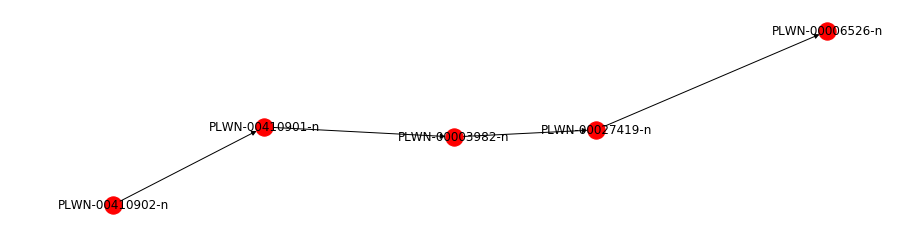

In [5]:
# Znajdź domknięcie przechodnie relacji hiperonimi dla pierwszego znaczenia wyrażenia wypadek drogowy 
# i przedstaw je w postaci grafu skierowanego.
meaning = wnquery.lookUpSense('wypadek drogowy', 1, 'n')
graph = []

def traceRelation(wnquery, wnid, pos, rel):
    res = []
    ids = wnquery.lookUpRelation(wnid, pos, rel)
    res.append(wnid)
    print(wnquery.getSynset(wnid, 'n').toString())
    for i in ids:  
        graph.append((wnid, i))
        res.extend(traceRelation(wnquery, i, pos, rel))
    return res

traceRelation(wnquery, meaning.wnid, 'n', 'hypernym')

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from(graph)
plt.figure(figsize=(12,3)) 
nx.draw_spring(G, with_labels = True)
plt.show()

In [6]:
# Znajdź bezpośrednie hiponimy rzeczownika wypadek1.
meaning = wnquery.lookUpSense('wypadek', 1, 'n')
relation = wnquery.lookUpRelation(meaning.wnid, meaning.pos, 'hyponym')
for meaning in relation:
    print(wnquery.getSynset(meaning, 'n').toString())

PLWN-00001284-n  {zderzenie:2, kraksa:1}  ()
PLWN-00006486-n  {kolizja:2}  ()
PLWN-00016131-n  {karambol:1}  ()
PLWN-00034688-n  {zawał:2}  ()
PLWN-00034689-n  {tąpnięcie:1}  ()
PLWN-00241026-n  {kapotaż:1}  ()
PLWN-00258639-n  {wykolejenie:2}  ()
PLWN-00389170-n  {zakrztuszenie:1, zachłyśnięcie:1, aspiracja:3}  ()
PLWN-00410901-n  {wypadek komunikacyjny:1}  ()
PLWN-00411618-n  {katastrofa budowlana:1}  ()
PLWN-00436137-n  {wypadek jądrowy:1}  ()


In [7]:
# Znajdź hiponimy drugiego rzędu dla rzeczownika wypadek1.
meaning = wnquery.lookUpSense('wypadek', 1, 'n')
relation = wnquery.lookUpRelation(meaning.wnid, meaning.pos, 'hyponym')
for meaning in relation:
    synset = wnquery.getSynset(meaning, 'n')
    relations = wnquery.lookUpRelation(synset.wnid, synset.pos, 'hyponym')
    for rel in relations:
        print(wnquery.getSynset(rel, 'n').toString())

PLWN-00235346-n  {czołówka:9, zderzenie czołowe:1}  ()
PLWN-00471555-n  {stłuczka:1}  ()
PLWN-00441365-n  {kolizja drogowa:1}  ()
PLWN-00037295-n  {obwał:1}  ()
PLWN-00410902-n  {wypadek drogowy:1}  ()


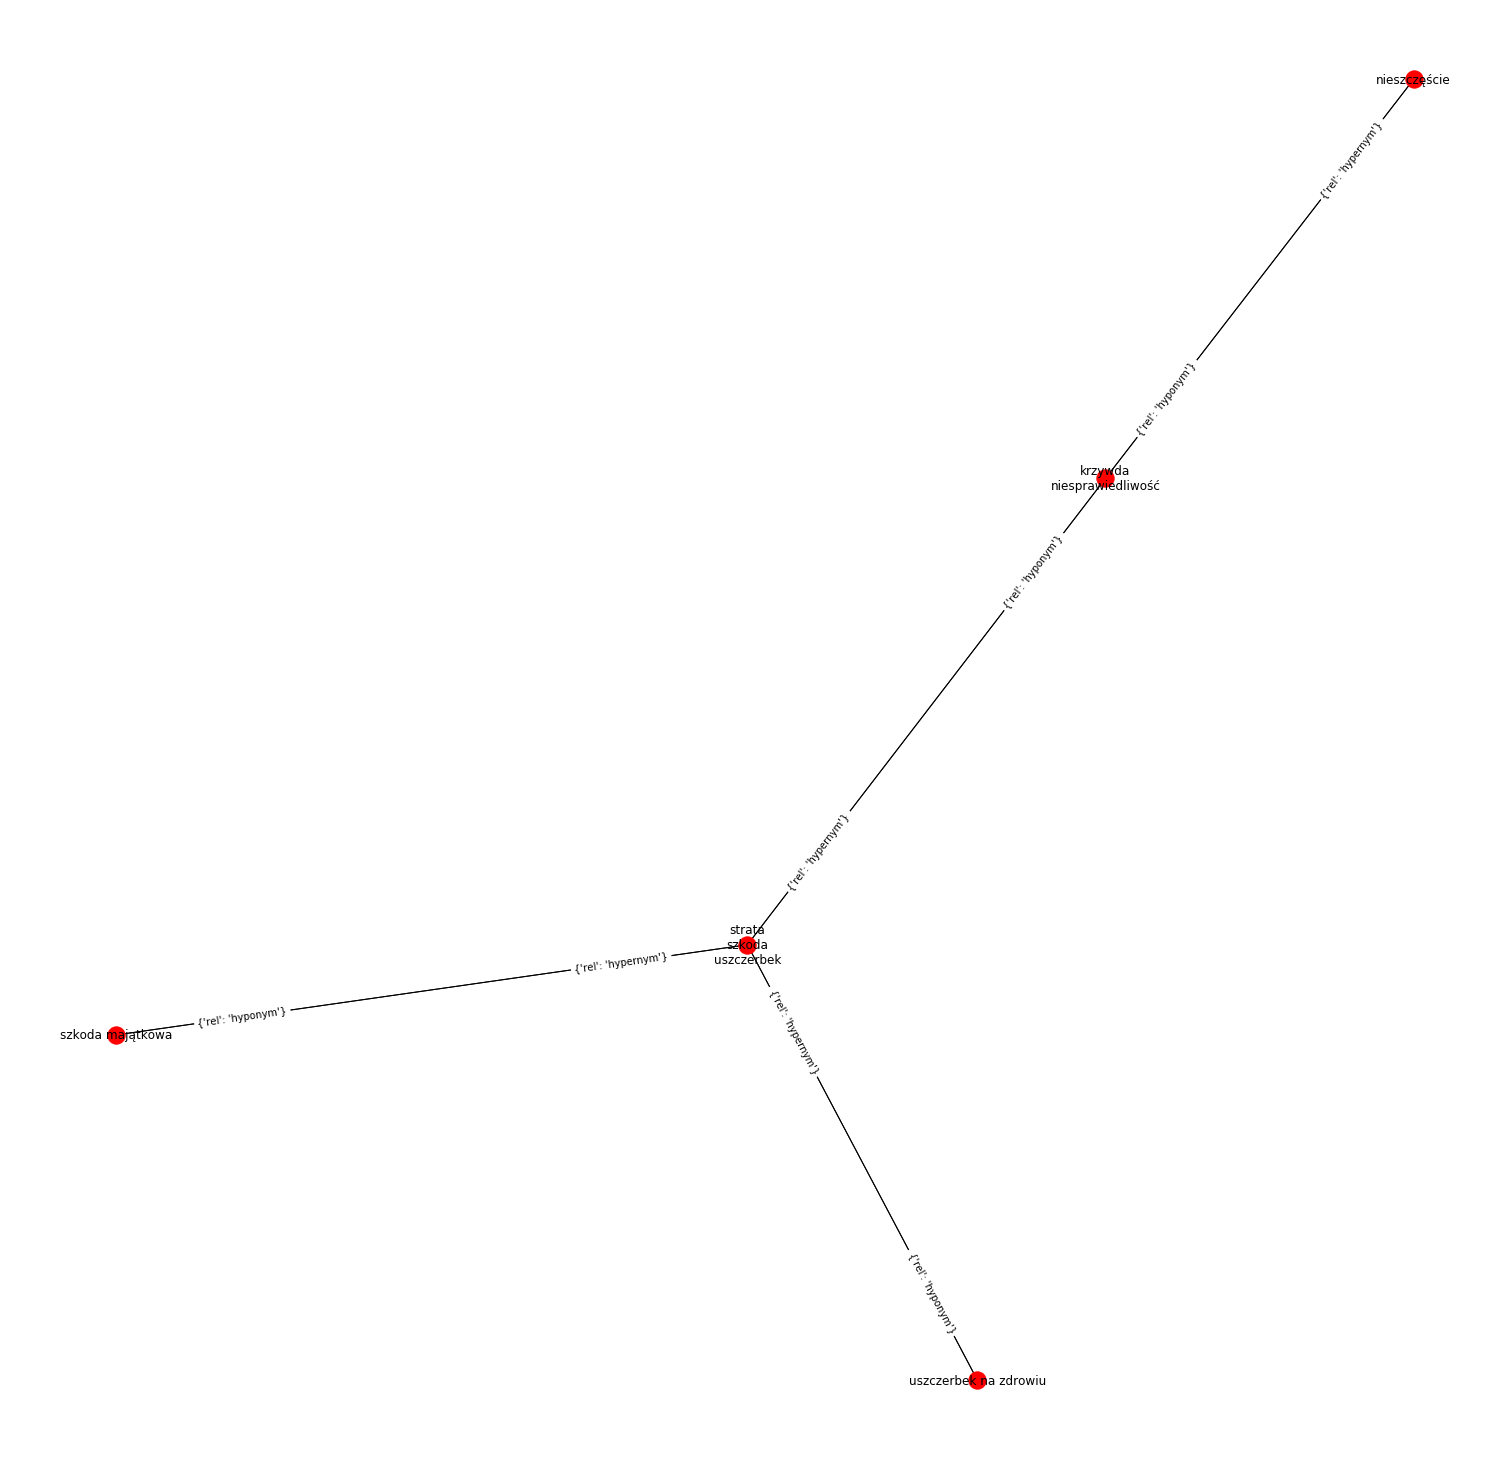

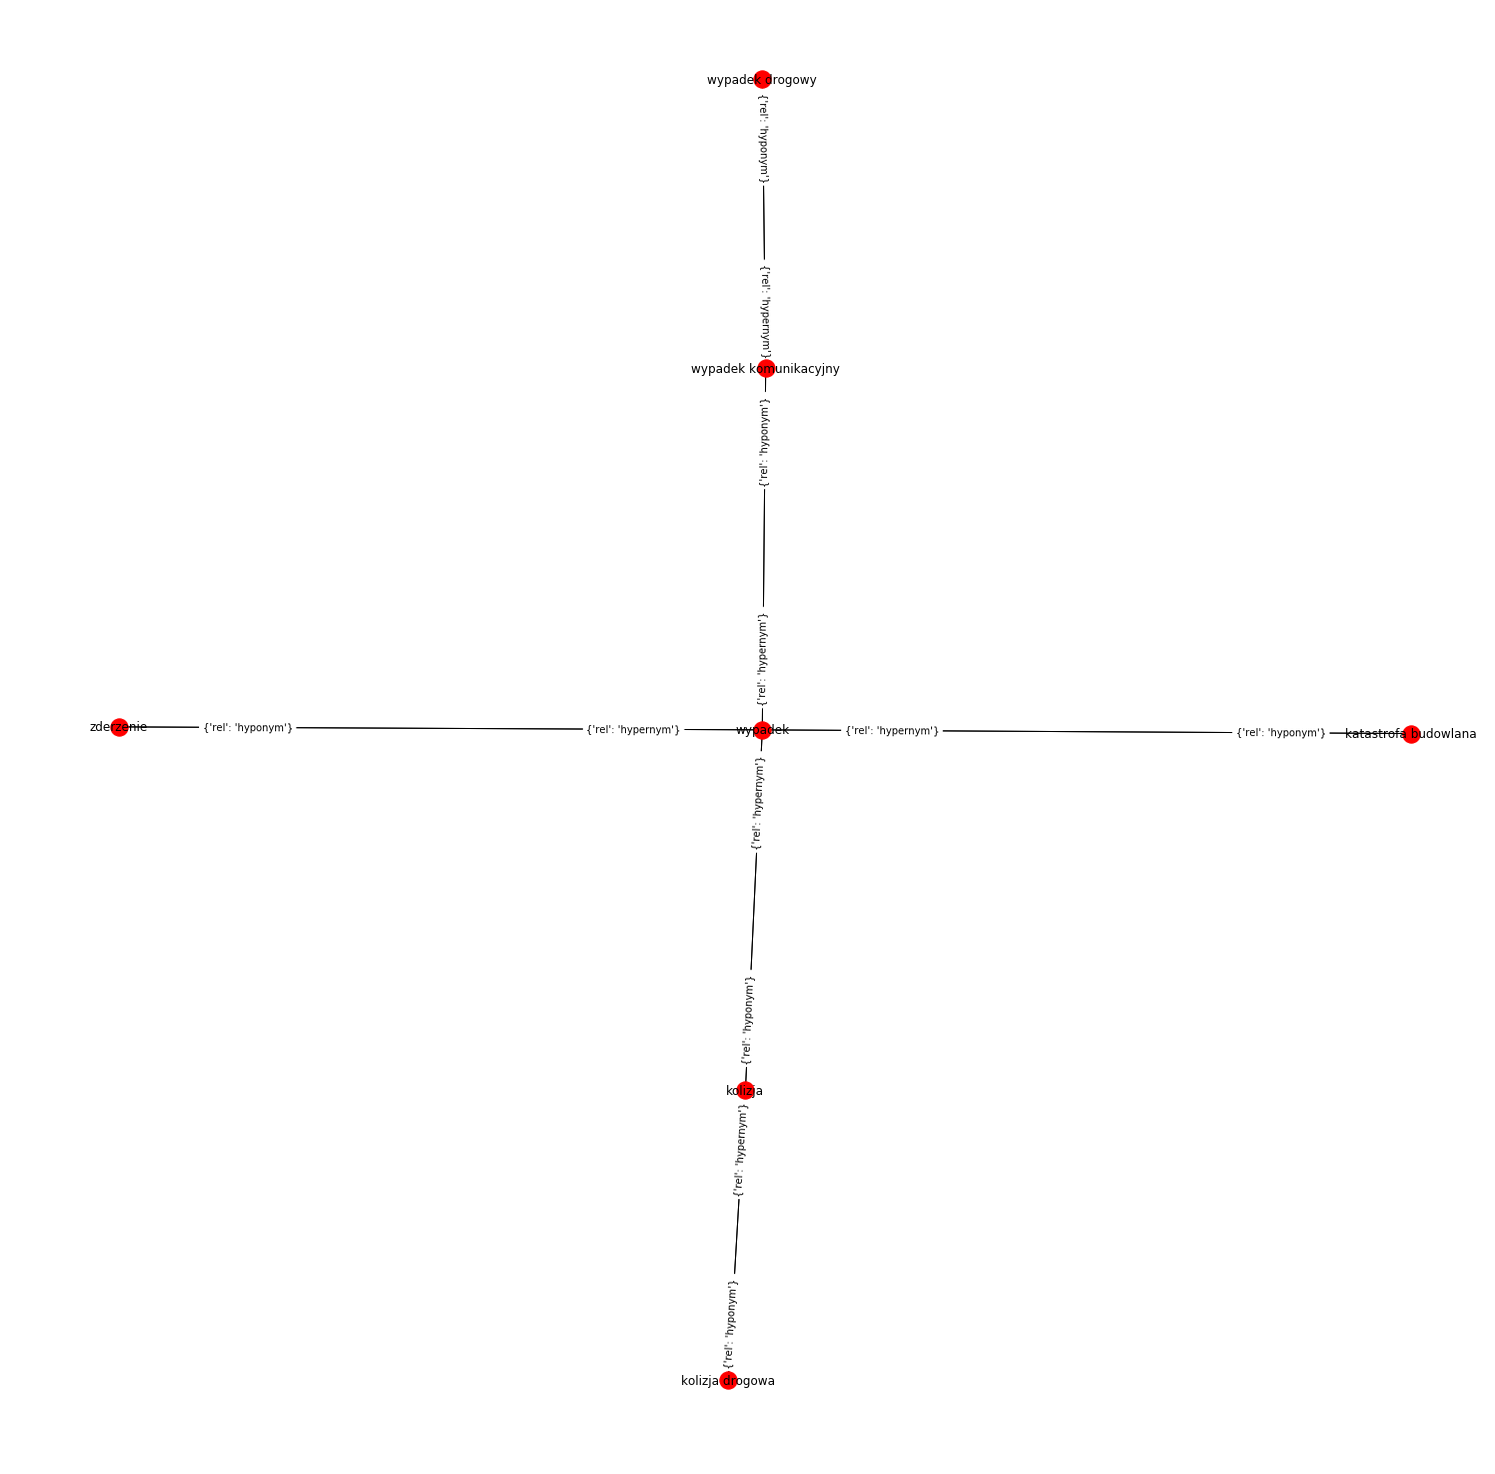

In [8]:
# Przedstaw w postaci grafu skierowanego (z etykietami dla krawędzi) relacje semantyczne pomiędzy następującymi grupami leksemów:
# szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
literals1 = {'szkoda': 1, 'strata': 1, 'uszczerbek': 1, 'szkoda majątkowa': 1, 'uszczerbek na zdrowiu': 1, 'krzywda': 1,
             'niesprawiedliwość': 1, 'nieszczęście': 2}

# wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, 
# katastrofa budowlana1, wypadek drogowy1.
literals2 = {'wypadek': 1, 'wypadek komunikacyjny': 1, 'kolizja': 2, 'zderzenie': 2, 'kolizja drogowa': 1, 
             'katastrofa budowlana': 1, 'wypadek drogowy': 1}

def get_synset_literals(synset, literals):
    return '\n'.join(filter(lambda x: x in literals, [synonym.literal for synonym in synset.synonyms]))

import itertools
def draw_relations(literals, skip=[]):
    synsets = [wnquery.lookUpSense(literal, pos, 'n') for literal, pos in literals.items()]
    synsets_ids = [synset.wnid for synset in synsets]
    
    G = nx.DiGraph()
    meaningful_relations = {}
    for synset in synsets:
        for target_id, relation_type in synset.ilrs:
            if target_id in synsets_ids:
                if relation_type not in skip:
                    G.add_edge(get_synset_literals(synset, literals), 
                               get_synset_literals(wnquery.lookUpID(target_id, 'n'), literals), 
                               rel=relation_type)

    plt.figure(figsize=(20,20)) 
    G.add_edges_from(meaningful_relations.keys())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, arrows=False)
    nx.draw_networkx_edge_labels(G, pos, label_pos=0.2)
    plt.show()
    
#prevent overlapping of labels
draw_relations(literals1)
draw_relations(literals2)

In [12]:
# Znajdź wartość miary pokrewieństwa semantycznego Leacocka-Chodorowa 
# pomiędzy następującymi parami leksemów:
# szkoda2 - wypadek1, kolizja2 - szkoda majątkowa1, nieszczęście2 - katastrofa budowlana1.

synsets = [(wnquery.lookUpSense('szkoda', 2, 'n'), wnquery.lookUpSense('wypadek', 1, 'n')),
           (wnquery.lookUpSense('kolizja', 2, 'n'), wnquery.lookUpSense('szkoda majątkowa', 1, 'n')),
           (wnquery.lookUpSense('nieszczęście', 2, 'n'), wnquery.lookUpSense('katastrofa budowlana', 1, 'n'))]

def get_distance(synset_pair):
    paths = []
    print("%s Path to root: " % synset_pair[0].wnid + str(wnquery.getReach(synset_pair[0].wnid, 'n', 'hypernym', True)))
    print("%s Path to root: " % synset_pair[1].wnid + str(wnquery.getReach(synset_pair[1].wnid, 'n', 'hypernym', True)))
    first_to_top =  wnquery.getReach(synset_pair[0].wnid, 'n', 'hypernym', True)
    second_to_top = wnquery.getReach(synset_pair[1].wnid, 'n', 'hypernym', True)
    for first_on_path in first_to_top:
        for second_on_path in second_to_top:
            if first_on_path[0] == second_on_path[0]:
                paths.append(first_on_path[1] + second_on_path[1] - 1)
    print(paths)
    return min(paths)

import math
for synset_pair in synsets:
    distance = get_distance(synset_pair)
    lch = -math.log(distance / (2.0 * (max(wnquery.getMaxDepth(wnid, 'n', 'hypernym') for wnid in wnquery.m_ndat))))
    print('Leacock-Chodorow: %f' % lch)

PLWN-00003675-n Path to root: [('PLWN-00003675-n', 1), ('PLWN-00235811-n', 2), ('PLWN-00002944-n', 3), ('PLWN-00036469-n', 4), ('PLWN-00036467-n', 5), ('PLWN-00000323-n', 6), ('#TOP#', 7), ('PLWN-00102819-n', 2), ('PLWN-00027419-n', 3), ('PLWN-00006526-n', 4), ('#TOP#', 5)]
PLWN-00003982-n Path to root: [('PLWN-00003982-n', 1), ('PLWN-00027419-n', 2), ('PLWN-00006526-n', 3), ('#TOP#', 4)]
[10, 4, 6, 8]
Leacock-Chodorow: 2.862201
PLWN-00006486-n Path to root: [('PLWN-00006486-n', 1), ('PLWN-00003982-n', 2), ('PLWN-00027419-n', 3), ('PLWN-00006526-n', 4), ('#TOP#', 5)]
PLWN-00472552-n Path to root: [('PLWN-00472552-n', 1), ('PLWN-00003675-n', 2), ('PLWN-00235811-n', 3), ('PLWN-00002944-n', 4), ('PLWN-00036469-n', 5), ('PLWN-00036467-n', 6), ('PLWN-00000323-n', 7), ('#TOP#', 8), ('PLWN-00102819-n', 3), ('PLWN-00027419-n', 4), ('PLWN-00006526-n', 5), ('#TOP#', 6)]
[6, 8, 12, 10]
Leacock-Chodorow: 2.456736
PLWN-00005640-n Path to root: [('PLWN-00005640-n', 1), ('PLWN-00031390-n', 2), ('PLWN

In [14]:
print(max(wnquery.getMaxDepth(wnid, 'n', 'hypernym') for wnid in wnquery.m_ndat))

35
